# The Objective

## Objective function

Our team's business mainly focuses on how to provide general users movies that they like. There are so many movies come out every year, but people won't watch all of them. Our business goal is to provide personalized movies that just fit for you. Once you think our services fit your taste, we could provide you even more novel movies, shows, or tv series by subscription to our website. We hope our technology could ultimately benefit individuals and push the entertainment industry forward.

**Our main strategy is to recommend 5 movies to each user on the platform by first recommending 50 movies then sorting them by a deep learning model with genre preference of user to get top 5.**

## Intended users
The recommendation system is created for the general audience so that everyone who enjoys movies benefits from our website.

## Business rules
In order to keep the user entertained rather than only focusing on what they already know, one business rule we came up with is to include at least two different genres when recommending k movies even though the predicted rating might be low. We would love our users to explore things that they would really want to try but haven't had chance to try yet. Compare to other recommendation system, the advantage of ours is we aim for not only the accuracy but also the spirit of exploration and curiosity.

## Performance requirements
For performance, we would like to serve the online queries in real time. For model based algorithms, it’s fine to train it offline and then serve the model online. We will update our database regularly so that our model is the most recent one. For this homework, we did not expand our scope on serving in real time. Everything we done was in an offline setting.

## Interpretability
In order to interpret models and to serve our subscribed users better (getting to know their behaviours and interests more), we decide to make the **matrix factorization** algorithm to only produce non-negative matrices. In that case, we would be able to identify some elements that are important for the algorithm to learn users’ behaviours (higher value in the matrices would produce higher ratings). For the more sophisticated model (**wide and deep**), if possible later on, we want to try to study and understand the users behaviours through the embeddings by the neural network.

# The Environments

Enviroment setup

In [1]:
import os
repo_name = 'final-project-qrdecomposition_final'
data_path = '../downloads'

if not os.path.isdir(data_path):
    os.mkdir(data_path)

## Download Movielens-latest

In [2]:
# import requests, zipfile, io
# url = "http://files.grouplens.org/datasets/movielens/ml-latest.zip"
# r = requests.get(url)
# with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
#     for zip_info in zf.infolist():
#         if zip_info.filename[-1] == '/':
#             continue
#         zip_info.filename = os.path.basename(zip_info.filename)
#         zf.extract(zip_info, data_path)

In [3]:
movie_info_path = '../data/movies.csv'
!cp $movie_info_path $data_path

In [4]:
#sanity check for downloaded files
!ls $data_path

model_results movies.csv    samples


## Import Libararies

In [5]:
###utilities
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

###pyspark dependencies
from pyspark.sql import SparkSession
import pyspark.ml as M
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T
from pyspark.ml.recommendation import ALS

###numpy,scipy,pandas,sklearn stacks
from scipy import sparse
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
#plt env
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

###torch stacks
import torch
from torch import nn
from pytorch_widedeep.preprocessing import DensePreprocessor
from pytorch_widedeep.callbacks import (
    LRHistory,
    EarlyStopping,
    ModelCheckpoint,
)
from pytorch_widedeep.optim import RAdam
from pytorch_widedeep.initializers import XavierNormal, KaimingNormal
from pytorch_widedeep.models import Wide, DeepDense, WideDeep
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device, torch.__version__)

cpu 1.7.0


## Initiate Spark Session

In [6]:
# os.environ["JAVA_HOME"] = "/datasets/home/65/965/yux164/.jdk/jdk-11.0.9.1+1" #for java path
import psutil
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
NUM_WORKER = psutil.cpu_count(logical = False)
NUM_THREAD = psutil.cpu_count(logical = True)
def spark_session():
    """[function for creating spark session]

    Returns:
        [Spark Session]: [the spark session]
    """    
    conf_spark = SparkConf().set("spark.driver.host", "127.0.0.1")\
                            .set("spark.executor.instances", NUM_WORKER)\
                            .set("spark.executor.cores", int(NUM_THREAD / NUM_WORKER))\
                            .set("spark.executor.memory", '4g')\
                            .set("spark.sql.shuffle.partitions", NUM_THREAD)
    sc = SparkContext(conf = conf_spark)
    sc.setLogLevel('ERROR')
    spark = SparkSession(sc)
    print('Spark UI address {}'.format(spark.sparkContext.uiWebUrl))
    return spark

spark = spark_session()

Spark UI address http://127.0.0.1:4041


# The Data


## Sample

We will first test our model on the sample of Movielens-ml-latest in homework2.

**sampling methodology**

We perform sampling w.r.t Conditional Matrix Sampling, in which, we will sample the matrix of $M$ user indices and $N$ movie indices filtering out users who do not have at least $i$ ratings and movies which do not have at least $j$ ratings. If numbers of users and movies do not meet the minimal requirements $M$ and $N$, we will keep sampling process with increased number of matrix indices for both users and movies until users and movies meet minimal requirements $M$ and $N$.

In our case, we choose M = 20000, N = 2000, i = 100, j = 1000. 20000 users, 2000 movies, a user should at least rate 100 movies and a movie should be at least rated 1000 times. We choose a denser matrix than homework 2's sample because of we need more ground truth of recommendation when we evaluate our model. That is, the base model selects 50 items to recommend, then in our test set, on average each user should have 50 items or more rated then we can evaluate our model based on the test set. 

In [7]:
#running this cell takes over minutes
def sampling(ratings,
            num_user, 
            num_item, 
            user_threshold, 
            item_threshold, 
            random_seed,
            userCol='userId', 
            itemCol='movieId',
            timeCol = 'timestamp',
            targetCol='rating'):
    """[method to generating sample from BIG dataset]

    Args:
        ratings (Pyspark DataFrame): [the BIG dataset]
        num_user (int): [the number of users needs to have in the sample]
        num_item (int): [the number of items needs to have in the sample]
        user_threshold (int): [the number of ratings a user needs to have]
        item_threshold (int): [the number of ratings a movie needs to have]
        random_seed (int): [random seed of random sample]
        userCol (str, optional): [user column name]. Defaults to 'userId'.
        itemCol (str, optional): [item column name]. Defaults to 'movieId'.
        timeCol (str, optional): [timesampe column name]. Defaults to 'timestamp'.
        targetCol (str, optional): [rating/target column name]. Defaults to 'rating'.

    Returns:
        Pyspark DataFrame: [the sample]
    """    
    n_users, n_items = 0, 0
    M, N = num_item, num_user
    while n_users < num_user and n_items < num_item:
        movieid_filter = ratings.groupby(itemCol)\
            .agg(F.count(userCol)\
            .alias('cnt'))\
            .where(F.col('cnt') >= item_threshold)\
            .select(itemCol)\
            .orderBy(F.rand(seed=random_seed))\
            .limit(M)
        sample = ratings.join(movieid_filter,
                                ratings[itemCol] == movieid_filter[itemCol])\
                            .select(ratings[userCol], ratings[itemCol], ratings[timeCol], ratings[targetCol])
        userid_filter = sample.groupby(userCol)\
                        .agg(F.count(itemCol)\
                        .alias('cnt'))\
                        .where(F.col('cnt') >= user_threshold)\
                        .select(userCol)\
                        .orderBy(F.rand(seed=random_seed))\
                        .limit(N)
        sample = sample.join(userid_filter,
                                ratings[userCol] == userid_filter[userCol])\
                            .select(ratings[userCol], ratings[itemCol], ratings[timeCol], ratings[targetCol]).persist()
        n_users, n_items = sample.select(userCol).distinct().count(), sample.select(itemCol).distinct().count()
        print(f'sample has {n_users} users and {n_items} items')
        M += 100
        N += 100
    return sample


how we generate our sample

```python
num_user = 20000
num_movie = 2000
user_threshold = 100
item_threshold = 1000
random_seed = 0
ratings = spark.read.csv(os.path.join(data_path,'ratings.csv'), header=True)
sample = sampling(ratings,num_user, num_movie, user_threshold, item_threshold, random_seed)
# save sample data to '/data/sample.csv'
sample = sample.persist()
sample.toPandas().to_csv(os.path.join(data_path, 'sample.csv'), index = False)
```

In [8]:
#load sample from local path
compressed_sample_path = '../data/sample.tar.gz'
!tar -xzvf $compressed_sample_path -C $data_path
!ls $data_path

sample_path = os.path.join(data_path, 'samples', 'sample.csv')
sample = spark.read.csv(sample_path, header=True).select('userId', 'movieId', 'rating').persist()
sample_df = pd.read_csv(sample_path).drop('timestamp', axis = 1)

x samples/
x samples/sample_train.csv
x samples/sample.csv
x samples/sample_test.csv
model_results movies.csv    samples


In [9]:
#sanity check for sample
sample.show(10)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     4|      1|   4.0|
|     4|      5|   2.0|
|     4|      6|   4.5|
|     4|     10|   4.0|
|     4|     11|   3.5|
|     4|     20|   2.5|
|     4|     23|   3.0|
|     4|     31|   3.0|
|     4|     32|   4.5|
|     4|     44|   1.0|
+------+-------+------+
only showing top 10 rows



## sample overview



In [10]:
print(f'''
number of data points in the sample: {sample.count()},
number of unique users in the sample: {sample.select('userId').distinct().count()},
number of unique movies in the sample: {sample.select('movieId').distinct().count()},
average number of movies a user rated:{sample.groupby('userId').agg(F.count('movieId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]:.2f},
average number of ratings a movie received: {sample.groupby('movieId').agg(F.count('userId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]:.2f},
average rating: {sample.select(F.mean('rating')).collect()[0][0]:.2f},
standard deviation of rating: {sample.select(F.stddev('rating')).collect()[0][0]:.2f},
average rating by user: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]:.2f},
standard deviation of rating by user mean: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]:.2f},
average rating by movie: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]:.2f},
standard deviation of rating by movie mean: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]:.2f}
        ''')


number of data points in the sample: 4340404,
number of unique users in the sample: 20000,
number of unique movies in the sample: 2000,
average number of movies a user rated:217.02,
average number of ratings a movie received: 2170.20,
average rating: 3.46,
standard deviation of rating: 1.04,
average rating by user: 3.53,
standard deviation of rating by user mean: 0.44,
average rating by movie: 3.31,
standard deviation of rating by movie mean: 0.50
        


## The Evaluation

## Metrics


#### Root Mean Square Error (RMSE)
$RMSE = \sqrt{\frac{(\hat{y}-y)^2}{n}}$.
RMSE explains on average how far is our predictions of ratings from the real ratings. One of our strategies is we trained our models to reduce this distance as much as possible using a loss very similar to RMSE which is called Mean Squared Error. RMSE is better for presentation purposes because it has the same unit as our original target.

In [11]:
def rmse(with_pred_df, rating_col_name = "rating", pred_col_name = "prediction"):
    """[calculate rmse of the prediction]
    Args:
        with_pred_df (Pyspark DataFrame): [Pyspark DataFrame with target and prediction columns]
        rating_col_name (str, optional): [column of true values]. Defaults to "rating".
        pred_col_name (str, optional): [column of prediction values]. Defaults to "prediction".
    Returns:
        flaot: [rmse]
    """
    return with_pred_df.select(F.sqrt(F.sum((F.col(rating_col_name) - \
                        F.col(pred_col_name))**2)/F.count(rating_col_name))).collect()[0][0]

from sklearn.metrics import mean_squared_error
def rmse_numpy(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

### Evaluation for Model Accuracy

First step to evaluate our models is just treating the evaluation as normal Regression/Classification problems: by trainig the model with training set, and fitting the prediction in metrics on testing set. 


**we define ratings bigger or equal to 3 as `satifaction` or `positive`** 

**ratings smaller than 3 as `dissatifaction` or `negative`**

#### Accuracy 
We define user rates a movie with scoring larger or equal to 3 as good and smaller to 3 as bad. Accuracy explains the percentage of ratings that our model generated are agreed with what the true ratings users gave.

In [12]:
def acc(with_pred_df, rating_col_name = "rating", pred_col_name = "prediction"):
    """[calculate rmse of the prediction]
    Args:
        with_pred_df (Pyspark DataFrame): [Pyspark DataFrame with target and prediction columns]
        rating_col_name (str, optional): [column of true values]. Defaults to "rating".
        pred_col_name (str, optional): [column of prediction values]. Defaults to "prediction".
    Returns:
        float: [accuracy]
    """
    TP = ((F.col(rating_col_name) >= 3) & (F.col(pred_col_name) >= 3))
    TN = ((F.col(rating_col_name) < 3) & (F.col(pred_col_name) < 3))
    correct = with_pred_df.filter(TP | TN)
    return correct.count() / with_pred_df.count()

from sklearn.metrics import accuracy_score

def acc_numpy(true, pred):
    return accuracy_score((true >=3), (pred >= 3))


#### Precision



We will adopt `precision` as a metric when we evaluate our recommendation system.

The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` is the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [13]:
from sklearn.metrics import precision_score

#### Recall

We will adopt `Recall` as a metric when we choose our base model. This is another strategies that differentiate our system from others' and this metric also serves the purpose of our business goals. We optimize this metric because we would like to give users better experience by letting the model make more correct receommendations that the users truly like.

The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. In our case, we set the ratings larger or equal to 3 as positive instances and ratings smaller than 3 as negative instances. 

In [14]:
def recall(with_pred_df, rating_col_name = "rating", pred_col_name = "prediction"):
    TP = with_pred_df.filter((F.col(rating_col_name) >= 3) & (F.col(pred_col_name) >= 3)).count()
    FN = with_pred_df.filter((F.col(rating_col_name) >= 3) & (F.col(pred_col_name) < 3)).count()
    return TP / (TP + FN)

from sklearn.metrics import recall_score

def recall_numpy(true, pred):
    return recall_score((true >=3), (pred >= 3))

#### AUC and ROC curve
ROC examines the True positive rate vs. False positive rate. This measure gives us some understanding about the model on the recall as well. Beside recall, this measure also indicates how's our recall and false alarm (in this case, recommending bad movies but the model thinks is good to users) moves interactively.

AUC calculates the area under the ROC curve, which provide us a single scalar value to quantify.

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from seaborn import set_style,set_palette

def ROC(pred,truth):
    """
    given prediction and groundtruth labels, computes false positive
    rate and true positive rate
    """
    fpr, tpr, threshold = roc_curve(truth, pred)
    if auc(fpr,tpr)<0.5:
        fpr, tpr, threshold = roc_curve(truth, pred)

    return fpr,tpr

def _plot_ROC(auc_dict:dict):
    """
    plot ROC curves for the models in the provided dictionary
    @param auc_dict: a dictionary containing names of the models and their
    corresponding false positive rates and true positive rates
    @param display: whether to display the image or to save file, default to False and save to file
    @param fn: if display is False, fn will be used as the name to save the plot
    """
    
    # style setup to match with the rest of the report
    set_style("darkgrid")
    set_palette("deep")

    for k in auc_dict.keys():
        fpr,tpr=auc_dict[k]
        plt.plot(fpr,tpr,lw=2.5,label="{}, AUC= {:.1f}%".format(k,auc(fpr,tpr)*100))
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.plot([0,1],[0.001,1],'r--')
    plt.tight_layout()


def plot_ROC_numpy(true, preds, model_names):
    plt.figure()
    true_binary = true >= 3
    for pred, model_name in zip(preds, model_names):
        _plot_ROC({model_name: ROC(pred, true_binary)})
    plt.show() 

#### NDCG

Normalized Discounted Cumulative Gain can be calculated as following: $NDCG = \frac{DCG}{IDCG}$, where $DCG = \frac{1}{m}\sum{u=1}^{m} \sum_{j \in Iu}^{} \frac{2^{rel{uj}} - 1}{log_2(v_j+1)}$ and $IDCG$ is the ideal DCG.

In short explanation, NDCG would measure the quality of our recommended k movies for a user as a whole. It's a ranking quality measure. Compare to other metrics, this measure gives us a better understanding not only on individual movies but also how these movies are located on users perferences. If recommended movies are on user's top movies list, then we say the recommendation is good.

In [16]:
from sklearn.metrics import ndcg_score

def NDCG(rec,test):
    """
    if ratings are equal, we choose dense rank.
    
    Args:
        rec(pd.DataFrame): the model recommended movies and predictions for users in testset
        sample(pd.DataFrame): the testset with user and ratings for movies
    Return:
        NDCG of this serie of recommendations on the users in test
    """
    test_copy = test.copy(deep=True)
    rec_copy = rec.copy(deep=True)
    k = rec_copy.groupby('userId')['movieId'].count().unique()
    if len(k) > 1:
        print("not all users have same number of recommendations!")
        return -1
    k = k[0]
    # generate rank for each users of movies in test
    test_copy['Rank'] = test_copy[['userId','rating']].groupby("userId").rank(method='dense').squeeze()
    test_copy = test_copy[["userId",'movieId','Rank']]
    # this would filter out any irrelavent movies using inner join with the testset
    combine = pd.merge(left=test_copy,right=rec_copy,on=["userId","movieId"],how='inner')
    combine = combine[['userId','Rank']]
    combine['Rank/log2'] = combine.Rank.apply(lambda x:1/np.log2(x+1))
    DCG = combine['Rank/log2'].sum() / combine.userId.nunique()
    IDCG = sum([1/np.log2(i+1) for i in range(1,k+1)])
    return DCG/IDCG


#### Item Coverage

We folloed how Prof. Vintch talked about this metric on piazza. In offline setting, we define coverage as how many movies are recommended over the total number of distinct movies we have in our dataset

## Train Test Split

We perform train test split following splits based on every user's activities:
- train, test : $75\%, 25\%$


We only choose 75, 25 splits since scalibility of base models has already shown in hw2 and scalibility of deep learning model can be also demonstrated through scaling batch size or adopting more cloud computing power.

In [17]:
def train_test_split(ratings, split, usercol='userId', itemcol='movieId', timecol='timestamp', targetcol='rating'):
    """[function to make train test split with respect to user activities]
    Args:
        ratings (Pyspark DataFrame): [the rating DataFrame to be splitted]
        split (float): [proportion of training set]
        usercol (str, optional): [user column name]. Defaults to 'userId'.
        itemcol (str, optional): [item column name]. Defaults to 'movieId'.
        timecol (str, optional): [timestamp column name]. Defaults to 'timestamp'.
        targetcol (str, optional): [rating/target column name]. Defaults to 'rating'.
    Returns:
        [Pyspark DataFrame, PysparkDataFrame]: [description]
    """    
    window = W.Window.partitionBy(ratings[usercol]).orderBy(ratings[timecol].desc())
    ranked = ratings.select('*', F.rank().over(window).alias('rank'))
    rating_count = ratings.groupby(usercol).agg(F.count(itemcol).alias('cnt'))
    ranked = ranked.join(rating_count, ranked.userId == rating_count.userId)\
        .select(ranked[usercol], ranked[itemcol], ranked[targetcol], ranked.rank, rating_count.cnt)
    ranked = ranked.withColumn('position', 1 - F.col('rank')/F.col('cnt'))\
        .select(usercol, itemcol,targetcol, 'position')
    train = ranked.where(ranked.position < split).select(usercol, itemcol, targetcol)
    test = ranked.where(ranked.position >= split).select(usercol, itemcol, targetcol)
    return train, test


how we split the data

``` python

sample_train, sample_test = train_test_split(sample, .75)
sample_train, sample_test = sample_train.persist(), sample_test.persist()
# save to 'data/'
sample_train.toPandas().to_csv(os.path.join('../data', 'sample_train.csv'), index = False)
sample_test.toPandas().to_csv(os.path.join('../data', 'sample_test.csv'), index = False)

```

In [18]:
# load from local files
sample_train_path = os.path.join(data_path, 'samples', 'sample_train.csv')
sample_test_path = os.path.join(data_path, 'samples', 'sample_test.csv')
movie_path =  os.path.join(data_path, 'movies.csv')

sample_train = spark.read.csv(sample_train_path, header=True)
sample_test = spark.read.csv(sample_test_path, header=True)
sample_train_df = pd.read_csv(sample_train_path)
sample_test_df = pd.read_csv(sample_test_path)

movies = spark.read.csv(movie_path, header=True)
movies_df = pd.read_csv(movie_path)

sample_df = sample_df.merge(movies_df)
sample_train_df, sample_test_df = sample_train_df.merge(movies_df), sample_test_df.merge(movies_df)

In [19]:
print(sample.count(), sample_train.count(), sample_test.count())

print(sample_df.shape, sample_train_df.shape, sample_test_df.shape)

4340404 3255932 1084472
(4340404, 5) (3255932, 5) (1084472, 5)


# The Model

In our project, we choose Architechture A. The folloing image indicates our detailed pipeline of Model.

## Model Pipeline

The model pipeline combines the models w.r.t graph below.

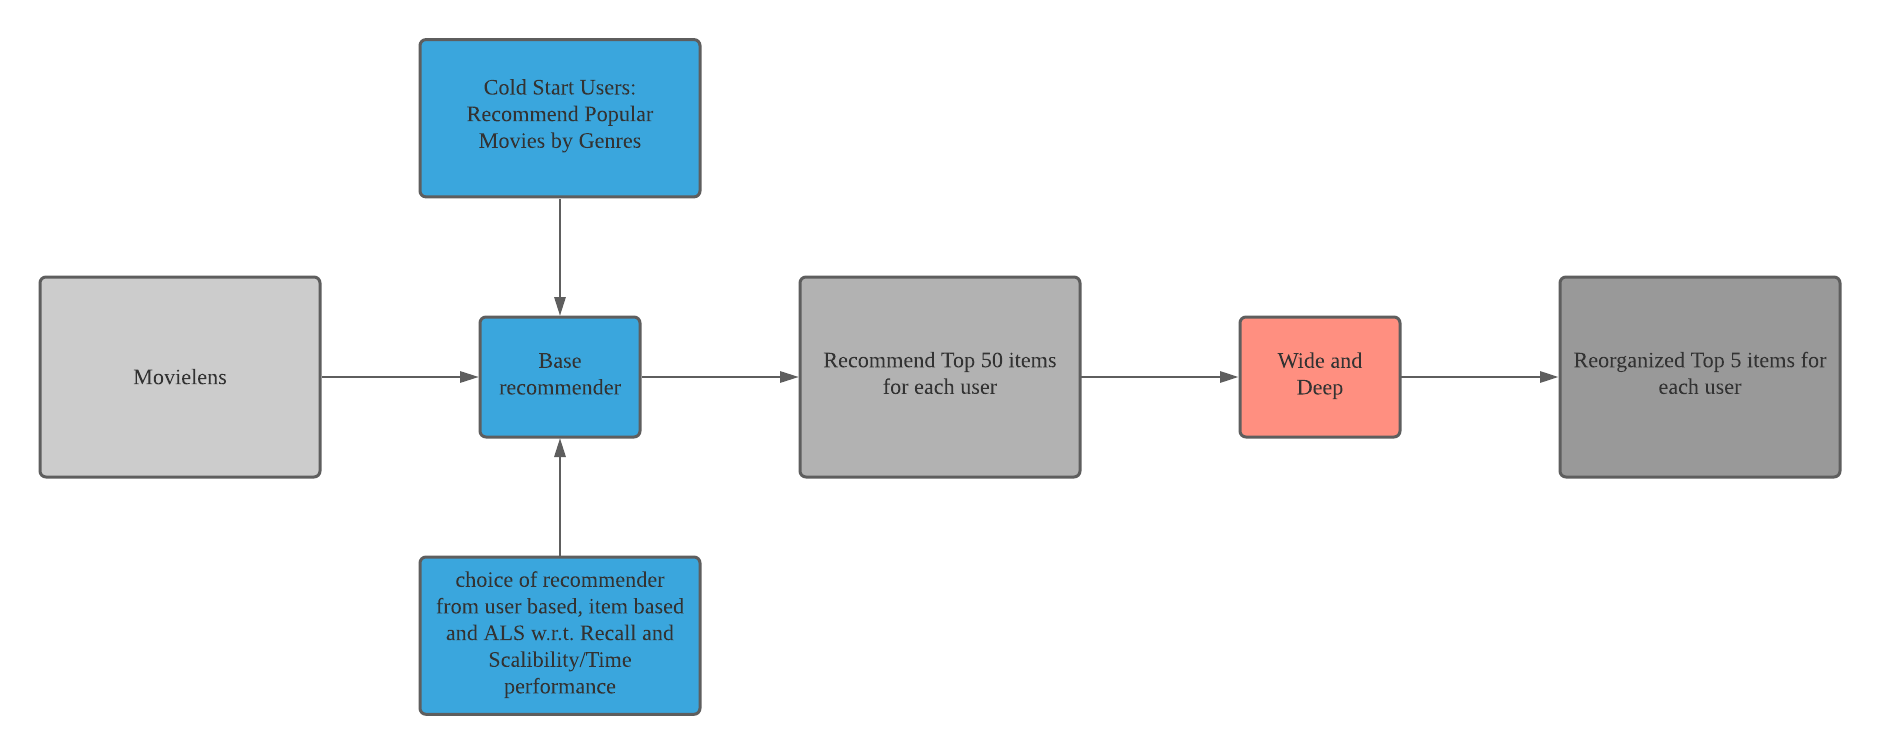

In [20]:
def base_recommend(spark, 
                   base_model, 
                   cold_start_model, 
                   user_ids, 
                   movies, 
                   n,
                   extra_features,
                   user_id, 
                   item_id):
    
    userset = list(set(user_ids))
    users = spark.createDataFrame(pd.DataFrame({base_model.userCol: userset}))
    base_recommend = base_model.recommend(users, n).toPandas()
    base_recommend = base_recommend.merge(movies, how='left')
    base_recommend = base_recommend[[user_id, item_id] + extra_features]
    base_recommend = base_recommend.astype({user_id: np.int64,
                                            item_id: np.int64})
    cold_start_users = set(user_ids) - set(base_recommend[user_id].tolist())
    for user in cold_start_users:
        cold_recommend = cold_start_model.recommend().toPandas().values.reshape(-1,)
        user_lst = [user for _ in range(n)]
        cold_recommendation = pd.DataFrame({user_id: user_lst, item_id: cold_recommend})
        cold_recommendation = cold_recommendation.astype({user_id: np.int64,
                                                        item_id: np.int64})
        cold_recommendation = cold_recommendation.merge(movies, how='left')
        cold_recommendation = cold_recommendation[[user_id, item_id] + extra_features]
        base_recommend = base_recommend.append(cold_recommendation, ignore_index=True)
    return base_recommend
def advanced_recommend(advanced_recommender,
                       base_recommend, 
                       k, 
                       user_id, 
                       item_id):
    df = base_recommend.copy()
    prediction = advanced_model.predict(df)
    df['prediction'] = prediction
    df = df.set_index(item_id).groupby(user_id).prediction\
        .apply(lambda x: x.sort_values(ascending=False)[:k]).reset_index()
    return df

def final_recommender(spark, 
                base_model, 
                cold_start_model, 
                advanced_recommender,
                users,
                movies,
                n = 50,
                k = 5,
                user_id = 'userId',
                item_id = 'movieId',
                extra_features = ['genres']
               ):
    base_recommend_items  = base_recommend(spark, base_model, cold_start_model, users, movies, n, extra_features, user_id, item_id)
    return advanced_recommend(advanced_recommender, base_recommend_items, k, user_id, item_id)

## Base Algorithms

We will choose a base algorithm from user based, item based, and model based (ALS) CF for our pipeline with consideration of the performance of their Recall and Inference Time (time to recommend). 

### Memory Based Collaborative Filtering

**implementation details**

The data first transformed into sparse matrix representation, (user by item) if user based and (item by user) if item based.

The the prediction matrix $R$ is trained with following formula:

$R$ is defined as $R_{i, j} = \mu_i + \frac{\sum_{v\in P_i(j)}S(i, v)\cdot (r_{vj} - \mu_v)}{\sum_{v\in P_i(j)}|S(i, v)|}$

where $S$ is the Pearson Similarity Matrix

$S$ is defined as $S_{u,v} = \frac{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)(r_{vk} - \mu_v)}{\sqrt{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)^2}\sqrt{\sum_{k \in I_u \cap I_v}(r_{vk} - \mu_v)^2}}$

The algorithm is implemented with numpy array (for prediction) and scipy csr sparse matrix (for training). 

Every operation uses numpy matrix operations (aka. dot product, norm, etc) which optimizes the computational speed by trading off extra memories (for loop takes $\approx 10$ minutes to train and matrix operations takes $\approx 1$ minutes to train for our experimental sample in user based CF).

**user based collabrative filtering**

When R is (user by item) and S is (user by user), it is User Based Collabrative Filtering

**item based collabrative filtering**

When R is (item by user) and S is (item by item), it is Item Based Collabrative Filtering

In [21]:
class Memory_based_CF():
    def __init__(self, spark, base, usercol='userId', itemcol='movieId', ratingcol='rating'):
        """[the memory based collabritive filtering model]
        Args:
            spark (Spark Session): [the current spark session]
            base (str): [user base or item base]
            usercol (str, optional): [user column name]. Defaults to 'userId'.
            itemcol (str, optional): [item column name]. Defaults to 'movieId'.
            ratingcol (str, optional): [rating/target column name]. Defaults to 'rating'.
        """        
        self.base = base
        self.usercol = usercol
        self.itemcol = itemcol
        self.ratingcol = ratingcol
        self.spark = spark
        self.X = None
        self.idxer = None
        self.similarity_matrix = None
        self.prediction_matrix = None
    def fit(self, _X):
        """[to train the model]
        Args:
            _X (Pyspark DataFrame): [the training set]
        """
        X = self._preprocess(_X, True)
        self.X = X
        self.similarity_matrix = self._pearson_corr(X)
        self.prediction_matrix = self._get_predict()
        
    def predict(self, _X):
        """[to predict based on trained model]
        Args:
            _X (Pyspark DataFrame): [the DataFrame needed to make prediction]
        Returns:
            [Pyspark DataFrame]: [the DataFrame with prediction column]
        """        
        rows, cols = self._preprocess(_X, False)
        preds = []
        for i,j in zip(rows,cols):   
            preds.append(self.prediction_matrix[i, j])
        df = self.idxer.transform(_X).select(self.usercol, self.itemcol, self.ratingcol).toPandas()
        df['prediction'] = preds
        return self.spark.createDataFrame(df)

    def recommend(self, X, numItem):
        idices = self.idxer.u_indxer.transform(X).toPandas()['userId_idx'].values.astype(int)
        items = np.asarray(np.argsort(self.prediction_matrix.T[idices, :])[:, -numItem:])
        result = np.zeros((1, 3))
        inverse_imat = pd.Series(self.idxer.i_indxer.labels)
        inverse_umat = pd.Series(self.idxer.u_indxer.labels)
        for u, i in zip(idices, items):
            result = np.vstack((result, np.hstack((inverse_umat.iloc[np.array([u for _ in range(len(i))])].values.reshape(-1, 1),
                                inverse_imat.iloc[i.reshape(-numItem,)].values.reshape(-1, 1), 
                                np.asarray(self.prediction_matrix.T[np.array([u for _ in range(len(i))]), i]).reshape(-1, 1)))))
        df = pd.DataFrame(result[1:], columns = ['userId', 'movieId', 'prediction'])
        return self.spark.createDataFrame(df)


    def _preprocess(self, X, fit):
        """[preprocessing function before training and predicting]
        Args:
            X (Pyspark DataFrame): [training/predicting set]
            fit (bool): [if it is on training stage or not]
        Raises:
            NotImplementedError: [if not User base or Item base]
        Returns:
            sparse.csr_matrix: [if on training stage],
            numpy.array: [row and columns in np.array if on prediction stage]
        """        
        if fit:
            self.idxer = indexTransformer(self.usercol, self.itemcol)
            self.idxer.fit(X)
            _X = self.idxer.transform(X)\
                            .select(F.col(self.usercol+'_idx').alias(self.usercol), 
                                    F.col(self.itemcol+'_idx').alias(self.itemcol), 
                                    F.col(self.ratingcol))
            _X = _X.toPandas().values
            if self.base == 'user':
                row = _X[:, 0].astype(int)
                col = _X[:, 1].astype(int)
                data = _X[:, 2].astype(float)
            elif self.base == 'item':
                row = _X[:, 1].astype(int)
                col = _X[:, 0].astype(int)
                data = _X[:, 2].astype(float)
            else:
                raise NotImplementedError
            return sparse.csr_matrix((data, (row, col)))
        else:
            _X = self.idxer.transform(X).select(self.usercol+'_idx', self.itemcol+'_idx').toPandas().values
            if self.base == 'user':
                row = _X[:, 0].astype(int)
                col = _X[:, 1].astype(int)
            elif self.base == 'item':
                row = _X[:, 1].astype(int)
                col = _X[:, 0].astype(int)
            else:
                raise NotImplementedError
            return row, col

    def _pearson_corr(self, A):
        """[generating pearson corretion matrix for the model when training]
        Args:
            A (sparse.csr_matrix): [the training set in sparse matrix form with entries of ratings]
        Returns:
            sparse.csr_matrix: [the pearson correlation matrix in sparse form]
        """        
        n = A.shape[1]
        
        rowsum = A.sum(1)
        centering = rowsum.dot(rowsum.T) / n
        C = (A.dot(A.T) - centering) / (n - 1)
        
        d = np.diag(C)
        coeffs = C / np.sqrt(np.outer(d, d))
        return np.array(np.nan_to_num(coeffs)) - np.eye(A.shape[0])
    def _get_predict(self):
        """[generating prediction matrix]
        Returns:
            sparse.csr_matrix: [the prediction matrix in sparse form]
        """        
        mu_iarray = np.array(np.nan_to_num(self.X.sum(1) / (self.X != 0).sum(1))).reshape(-1)
        mu_imat = np.vstack([mu_iarray for _ in range(self.X.shape[1])]).T
        x = self.X.copy()
        x[x==0] = np.NaN
        diff = np.nan_to_num(x-mu_imat)
        sim_norm_mat = abs(self.similarity_matrix).dot((diff!=0).astype(int))
        w = self.similarity_matrix.dot(diff) / sim_norm_mat
        w = np.nan_to_num(w)
        return mu_imat + w
class indexTransformer():
    """[helper class for memory based model]
    """    
    def __init__(self, usercol='userId', itemcol='movieId', ratingcol='rating'):
        """[the index transformer for matrix purpose]
        Args:
            usercol (str, optional): [user column name]. Defaults to 'userId'.
            itemcol (str, optional): [item column name]. Defaults to 'movieId'.
        """        
        self.usercol = usercol
        self.itemcol = itemcol
        self.ratingcol = ratingcol
        self.u_indxer =  M.feature.StringIndexer(inputCol=usercol, 
                                                outputCol=usercol+'_idx', 
                                                handleInvalid = 'skip')
        self.i_indxer = M.feature.StringIndexer(inputCol=itemcol, 
                                                outputCol=itemcol+'_idx', 
                                                handleInvalid = 'skip')
        self.X = None
    def fit(self, X):
        """[to train the transformer]
        Args:
            X (Pyspark DataFrame): [the DataFrame for training]
        """        
        self.X = X
        self.u_indxer = self.u_indxer.fit(self.X)
        self.i_indxer = self.i_indxer.fit(self.X)
        return
    def transform(self, X):
        """[to transform the DataFrame]
        Args:
            X (Pyspark DataFrame): [the DataFrame needs to be transformed]
        Returns:
            Pyspark DataFrame: [the transformed DataFrame with index]
        """        
        X_ = self.u_indxer.transform(X)
        X_ = self.i_indxer.transform(X_)
        return X_.orderBy([self.usercol+'_idx', self.itemcol+'_idx'])
    
    def fit_transform(self, X):
        """[combining fit and transform]
        Args:
            X (Pyspark DataFrame): [the DataFrame needs to be trained and transformed]
        Returns:
            Pyspark DataFrame: [the transformed DataFrame with index]
        """        
        self.fit(X)
        return self.transform(X)

### Model Based Collaborative Filtering


**implementation details**

The data first casted userId and movieId into integers and then fit into `pyspark.ml.recommendation.ALS`.

Our implementation takes advantages of model based collaborative filtering algorithm implemented in `spark.ml`, in which users and products are described by a small set of latent factors that can be used to predict missing entries `spark.ml` uses the alternating least squares (ALS) algorithm to learn these latent factors.

Since there are many parameters in ALS of `spark.ml`, we will fix `nonnegative = True` in order to increase interpertability, and we will only select `regParam`(scale of regulization term) and `rank`(number of hidden factors) to be tuned. (We also tried to tune `maxIter` parameter, but when `maxIter > 20` will blow up memory in our machine with large `rank`, and it takes much longer with nearly the same results, so we will keep `maxIter` with default `=10`.)

In [22]:
class Als():
    """[the predictor for Pyspark ALS]
    """
    def __init__(self, userCol, itemCol, ratingCol, regParam, seed, rank):
        self.userCol = userCol
        self.itemCol = itemCol
        self.ratingCol = ratingCol
        self.model =None
        self.als = ALS(userCol=userCol,
                itemCol=itemCol,
                ratingCol=ratingCol,
                coldStartStrategy="drop",
                nonnegative=True,
                regParam=regParam,
                seed=seed,
                rank=rank)
    def fit(self, _X):
        """[function to train parameter of predictor]
        Args:
            _X (Pyspark DataFrame): [training set]
        """
        X = self._preprocess(_X)
        self.model = self.als.fit(X)

    def predict(self, _X):
        """[function to make predict over test set]
        Args:
            _X (Pyspark DataFrame): [test set]
        Returns:
            Pyspark DataFrame: [DataFrame with 'prediction' column which has the predicting value]
        """        
        X = self._preprocess(_X)
        return self.model.transform(X)

    def recommend(self, X, numItems):
        return self.model.recommendForUserSubset(X, numItems)\
                .select(self.userCol, F.explode('recommendations').alias('recommendations'))\
                .select(self.userCol, 'recommendations.*')\
                .select(self.userCol, self.itemCol, F.col(self.ratingCol).alias('prediction'))
    def _preprocess(self, _X):
        """[preprocess the input dataset]
        Args:
            _X (Pyspark DataFrame): [the training or test set]
        Returns:
            Pyspark DataFrame: [the preprocessed DataFrame]
        """
        cast_int = lambda df: df.select([F.col(c).cast('int') for c in [self.userCol, self.itemCol]] + \
                                [F.col(self.ratingCol).cast('float')])
        return cast_int(_X)

### Cold Start Model

If a new user comes to the system, we will generate 50 popular movies based on movie genre

In [23]:
class code_start():
    def __init__(self, movie):
        movie_copy = movie.withColumn("year",F.regexp_extract(movie.title,r"(\d{4})",0).cast(T.IntegerType()))
        movie_copy = movie_copy.withColumn("genre",F.explode(F.split(movie.genres,pattern="\|")))
        movie_copy = movie_copy.select("movieId","title","genre","year")
        genres = movie_copy.select("genre").distinct().toPandas()['genre'].tolist()

        sample_copy = sample.select("userId","movieId")

        total = sample_copy.join(movie_copy,["movieId"],'left')
        popular = total.groupby("movieId").count().sort("count",ascending=False)
        
        self.movie = movie
        self.popular = popular
        
    def recommend(self):
        return self.popular.select("movieId").limit(50).select('movieId')

## Advanced Algorithms

Our advanced algorithm is wide and deep algorithm

### Wide and Deep

Wide and Deep requires different kinds of feature engineering. We have tried out different kinds of features including `timestamp`, `genres` of movie, and `tags` of movie. By transforming `timestamp` to `year`, `month`, `day`, transforming `tags` into TF-IDF vectors, and transforming `genres` into one-hot vectors. But, the results were not very well. We end up with only using `genres` as wide feature, `user` and `movie` embedding as deep feature to create our wide and deep neural networks. 

The architechture of wide and deep is shown below

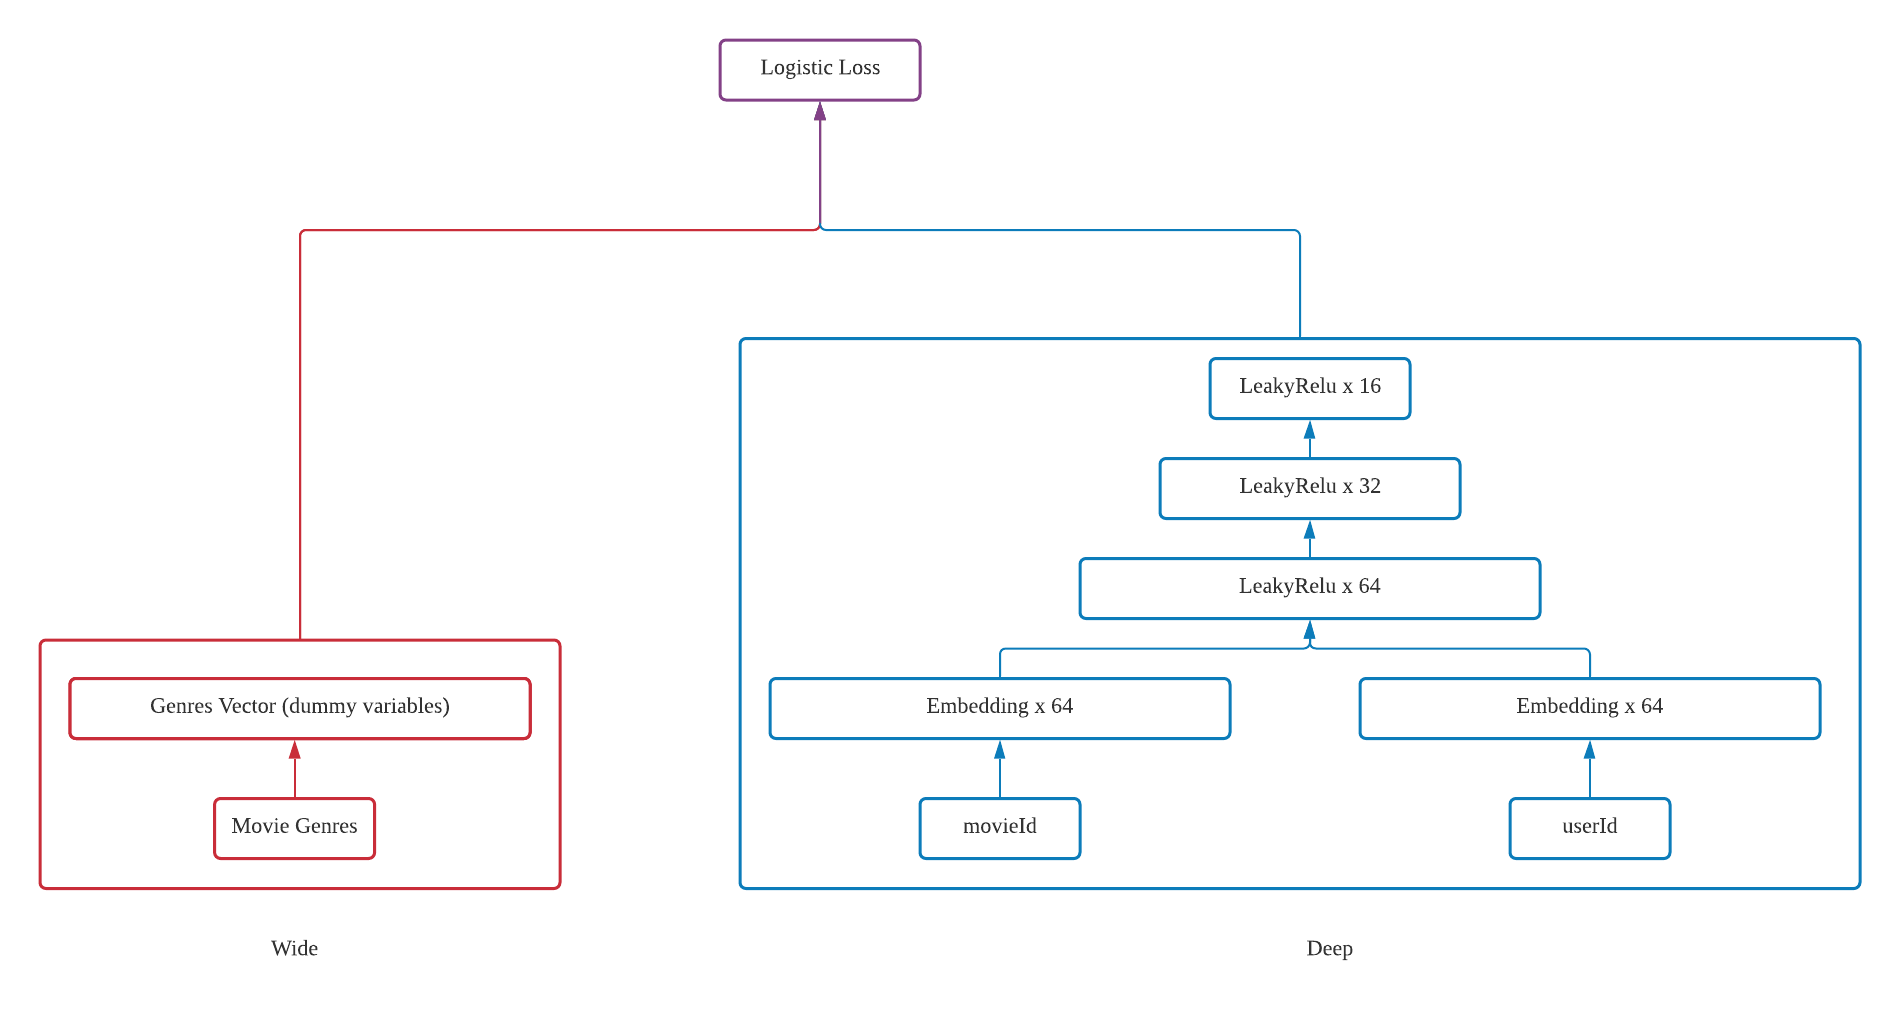

In [24]:
class wide_deep():
    def __init__(self,wide_cols='genres',
                    deep_cols=['userId', 'movieId'],
                    target_col = 'rating',
                    deep_embs=[64, 64],
                    deep_hidden=[64,32,16],
                    deep_dropout=[0.1, 0.1, .1],
                    deep_bachnorm=True):
        self.wide = None
        self.deep = None
        self.deep_hidden = deep_hidden
        self.deep_dropout = deep_dropout
        self.deep_bachnorm = deep_bachnorm
        self.model = None
        self.wide_cols = wide_cols
        self.deep_cols = deep_cols
        self.embs = [(col, dim) for col, dim in zip(deep_cols, deep_embs)]
        self.wide_preprocessor = self._genre_preprocessor(wide_cols)
        self.deep_preprocessor = DensePreprocessor(embed_cols=self.embs)
        self.target_col = target_col


    def fit(self, train, n_epochs=10, batch_size=128, val_split=.1, verbose = True):
        X, y = train.drop(self.target_col, axis = 1), train[self.target_col].values
        wide_feature = self.wide_preprocessor.fit_transform(X)
        deep_feature = self.deep_preprocessor.fit_transform(X)
        self.wide = Wide(wide_dim=np.unique(wide_feature).shape[0], pred_dim=1)
        self.deep = DeepDense(hidden_layers=self.deep_hidden, dropout=self.deep_dropout,
                      batchnorm=self.deep_bachnorm,
                      deep_column_idx=self.deep_preprocessor.deep_column_idx,
                      embed_input=self.deep_preprocessor.embeddings_input)
        self.model =  WideDeep(wide=self.wide, deepdense=self.deep)
        wide_opt = torch.optim.Adam(self.model.wide.parameters(), lr=0.01)
        deep_opt = RAdam(self.model.deepdense.parameters())
        wide_sch = torch.optim.lr_scheduler.StepLR(wide_opt, step_size=3)
        deep_sch = torch.optim.lr_scheduler.StepLR(deep_opt, step_size=5)
        callbacks = [
                        LRHistory(n_epochs=n_epochs),
                        EarlyStopping(patience=5),
                        ModelCheckpoint(filepath="model_weights/wd_out"),
                    ]
        optimizers = {"wide": wide_opt, "deepdense": deep_opt}
        schedulers = {"wide": wide_sch, "deepdense": deep_sch}
        initializers = {"wide": KaimingNormal, "deepdense": XavierNormal}
        self.model.compile(method='regression',
                            optimizers=optimizers,
                        lr_schedulers=schedulers,
                        initializers=initializers,
                        callbacks=callbacks,
                        verbose=verbose)
        self.model.fit(X_wide=wide_feature, 
                  X_deep=deep_feature, 
                  target=y, 
                  n_epochs=n_epochs, 
                  batch_size=batch_size, 
                  val_split=val_split,)
    def load_pretrained(self, train, fp, device):
        X = train.copy()
        if type(self.wide_cols) == str:
            wide_feature = self.wide_preprocessor.fit_transform(X[[self.wide_cols]])
        else:
            wide_feature = self.wide_preprocessor.fit_transform(X[self.wide_cols])
        deep_feature = self.deep_preprocessor.fit_transform(X[self.deep_cols])
        self.wide = Wide(wide_dim=np.unique(wide_feature).shape[0], pred_dim=1)
        self.deep = DeepDense(hidden_layers=self.deep_hidden, dropout=self.deep_dropout,
                      batchnorm=self.deep_bachnorm,
                      deep_column_idx=self.deep_preprocessor.deep_column_idx,
                      embed_input=self.deep_preprocessor.embeddings_input)
        self.model =  torch.load(fp,  map_location=torch.device(device))
        
    def predict(self, test):
        X = test.copy()
        wide_feature = self.wide_preprocessor.transform(X)
        deep_feature = self.deep_preprocessor.transform(X)
        return self.model.predict(X_wide=wide_feature, X_deep=deep_feature)

    def _genre_preprocessor(self, genre_feat):
        dense_layer = lambda X: X.toarray()
        genre_transformer = Pipeline(steps=[
                ('tokenizer', CountVectorizer()),
                ('dense', FunctionTransformer(dense_layer, validate=False))   
        ])
        preproc = ColumnTransformer(transformers=[('genre', genre_transformer, genre_feat),])
        return preproc


    def _deep_preprocessor(self,embs):
        return DensePreprocessor(embed_cols=embs)

# The Experiment

we used our train test split strategy mentioned above to evaluate our models and the system. We noticed that the recommenders might provide movies that are not existed in our test set. For most of the metrics, we will only consider those movies that are included in the test set (through inner join the recommendation list and the test set on movieId and userId).

In [25]:
compressed_sample_path = '../data/model_results.tar.gz'
!tar -xzvf $compressed_sample_path -C $data_path
!ls $data_path

x model_results/
x model_results/final_recommendations.csv
x model_results/item_based_recom_50.csv
x model_results/item_based_recom_5.csv
x model_results/als_recom_50.csv
x model_results/model_test_results.csv
x model_results/als_recom_5.csv
x model_results/base_model_selection.csv
model_results movies.csv    samples


## Choice of Base Model

Since `user based` CF allocates the memories over 16GB the colab assigned (Session Crashed), we will abandon choice of `user based` CF.

Thus, we will choose our base model based on the Recall and Time performance between `item based` CF and `ALS` of Matrix Factorization (Model Based CF) for our sample data. (We will use the tuned parameter for ALS from Homework 2, which is ragParam = .15, rank = 10)

We will test a benchmark on recommendation with constraint on test dataset to see how the recall is, and how the time cost of each base model.

### Recall and Recommendation Time in Test Set

how we train and generate our base model selection results
``` python
## live training and inference for base model
# this cell takes over minutes to execute

models = {'item_based': Memory_based_CF(spark, base='item', usercol='userId', itemcol='movieId', ratingcol='rating'),
  'als': Als(userCol='userId', itemCol='movieId', ratingCol='rating', regParam=.15, seed=0, rank=10)}
# this cell takes over minutes to execute
def recommend(prediction, k, userCol = 'userId', itemCol = 'movieId',ratingCol = 'rating', predCol = 'prediction'):
    window = W.Window.partitionBy(prediction[userCol]).orderBy(prediction['prediction'].desc())
    ranked = prediction.select('*', F.rank().over(window).alias('rank'))
    recommended = ranked.where(ranked.rank <= k).select(F.col(userCol).cast('string'), 
                                                        F.col(itemCol).cast('string'),
                                                        F.col(ratingCol).cast('double'),
                                                        F.col(predCol).cast('double'))
    return recommended
recalls = []
times = []
predictions = []
for model in models.keys():
    #training based model
    models[model].fit(sample_train)
    start = time.time()
    prediction = models[model].predict(sample_test)
    recommendation = recommend(prediction, 50)
    recalls.append(recall(recommendation))
    end = time.time()
    times.append(end - start)
    predictions.append(prediction)
base_model_selection = pd.DataFrame({'recall': recalls, 'recommend time': times}, index=['item_based', 'als'])
base_model_selection.to_csv('../model_results/base_model_selection.csv')

```

In [26]:
base_model_selection = pd.read_csv(os.path.join(data_path,'model_results/base_model_selection.csv'), index_col=0)
display(base_model_selection)

,recall,recommend time
item_based,0.917752,64.714004
als,0.842358,11.985038


### Recall

Recall for the recommenders recommend 50 items

In [27]:
item_based_50 = pd.read_csv('../downloads/model_results/item_based_recom_50.csv')
als_50 = pd.read_csv('../downloads/model_results/als_recom_50.csv')

item_based_50 = item_based_50.merge(sample_df)
als_50 = als_50.merge(sample_df)

item_based_50['pred_binary'] = item_based_50.prediction >= 3
als_50['pred_binary'] = als_50.prediction >= 3

item_based_50['true_binary'] = item_based_50.prediction >= 3
als_50['true_binary'] = als_50.prediction >= 3

print('recall@50 for item based CF {}'.format(recall_score(item_based_50.pred_binary, item_based_50.true_binary)))

print('recall@50 for ALS {}'.format(recall_score(als_50.pred_binary, als_50.true_binary)))

recall@50 for item based CF 1.0
recall@50 for ALS 1.0


For our sample dataset, from th table above, we observe that item-based CF outperforms als CF, but the running time of making recommendation by item_based dataset is much worser than by the als model. Considering real time scenario that users need instant recommedations, we will choose `ALS` as our base model.

## Other Measures for Models on Test Set

how we train wide and deep

``` python

wd = wide_deep()
wd.fit(sample_train_df)
test_pred = wd.predict(sample_test_df)

```

how we generate the results

```python

#getting prediction of base models
base_predictions = [pred.toPandas() for pred in predictions]
base_predictions = [pred.astype({'userId': np.int64, 'movieId': np.int64, 'rating': np.float64, 'prediction': np.float64}) \
 for pred in base_predictions]
for pred, model in zip(base_predictions, models.keys()):
    pred.columns = ['userId', 'movieId','rating', model+'_prediction']
results = sample_test_df[['userId', 'movieId','rating']].merge(base_predictions[0])
results = results.merge(base_predictions[1])

results['deep_wide_prediction'] = test_pred

results[['rating', 'item_based_prediction', 
        'als_prediction', 'deep_wide_prediction']].to_csv('../model_results/model_test_results.csv', index=False)

```

In [28]:
all_preds_test = pd.read_csv(os.path.join(data_path,'model_results/model_test_results.csv'))

In [29]:
all_preds_test.head()

,rating,item_based_prediction,als_prediction,deep_wide_prediction
0,2.0,3.134529,2.980006,2.637283
1,2.0,3.326562,3.043437,3.394947
2,3.0,2.848008,2.719941,3.399959
3,2.0,3.003214,2.716263,2.923458
4,3.5,3.473010,3.243872,3.199457


In [30]:
# Compute accuracy of each model
acc_item = acc_numpy(all_preds_test["rating"], all_preds_test["item_based_prediction"])
acc_als = acc_numpy(all_preds_test["rating"], all_preds_test["als_prediction"])
acc_deep = acc_numpy(all_preds_test["rating"], all_preds_test["deep_wide_prediction"])
accs = pd.DataFrame({"Item based": [acc_item], "ALS": [acc_als], 
                      "Wide and deep learning": [acc_deep]}, index=["Accuracy"])

# Compute RMSE of each model
rmse_item = rmse_numpy(all_preds_test["rating"], all_preds_test["item_based_prediction"])
rmse_als = rmse_numpy(all_preds_test["rating"], all_preds_test["als_prediction"])
rmse_deep = rmse_numpy(all_preds_test["rating"], all_preds_test["deep_wide_prediction"])
rmses = pd.DataFrame({"Item based": [rmse_item], "ALS": [rmse_als], 
                      "Wide and deep learning": [rmse_deep]}, index=["RMSE"])

pd.concat([accs, rmses])

,Item based,ALS,Wide and deep learning
Accuracy,0.80607,0.762328,0.799716
RMSE,0.82471,0.831761,0.822391


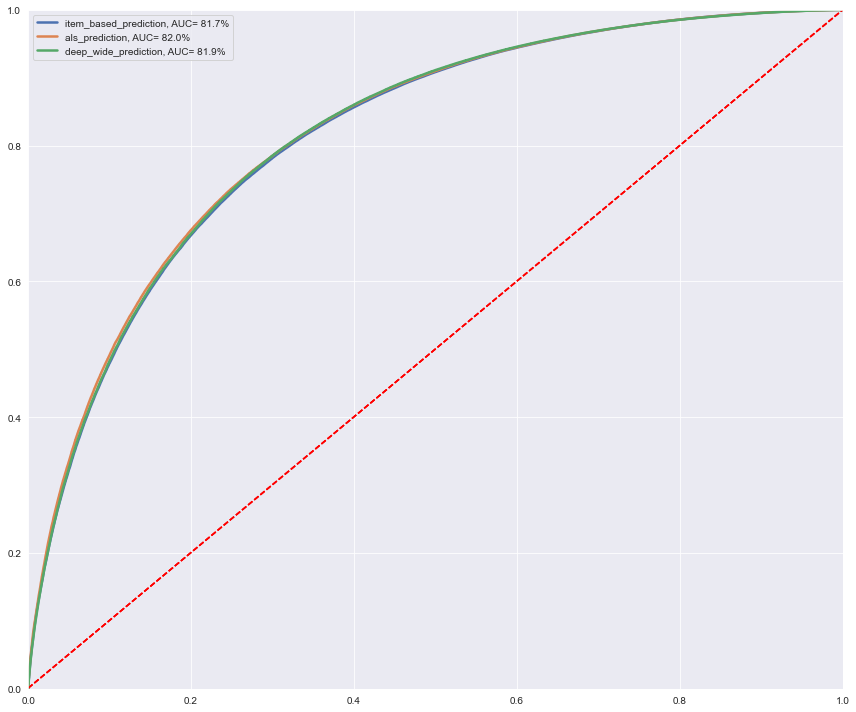

In [31]:
plot_ROC_numpy(all_preds_test.rating.values, list(all_preds_test[['item_based_prediction', 'als_prediction', 'deep_wide_prediction']].values.T),\
               ['item_based_prediction', 'als_prediction', 'deep_wide_prediction'])

### Observation

**Performance wise**

* According to the table above, from the perspective of accuracy, item based model has the highest accuracy
* we find that the RMSE of wide and deep model has the lowest root mean square error
* and  the ALS model has the highest score of area under curve


**Memory wise**

In the training process of wide and deep model, we set the size of minibatch to 128, which prevent large memory cost.

**Time wise**

Since the item based model takes 64 seconds to make recommendation while ALS model only costs 11 seconds, we chose ALS model as our baseline model. On the other hand, the wide and deep model after training spends about 19 seconds making recommendation.

## Experiment of Pipeline

How we run our pipeline

```python
train = sample_train_df.copy()
test = sample_test_df.copy()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#users to generate recommendation
users = test.userId.unique().tolist()

#base model has already trained in previous cells
## train base model
base_model = Als(userCol='userId', itemCol='movieId', ratingCol='rating', regParam=.15, seed=0, rank=10)
base_model.fit(sample_train)
## load cold start model
cold_start_model = code_start(movies)
## train wide and deep model
advanced_model = wide_deep()
### if we want to live train the wide and deep model
advanced_model.fit(sample_train_df)
### if we want to load pretrained model
advanced_model.load_pretrained(train, '../trained_model/wide_deep_sample.t', device)

#generate recommendation for users n = how many base model recommends, k = how many advanced model recommends
final_recommend_items = final_recommender(spark, 
                                          base_model, 
                                          cold_start_model, 
                                          advanced_model,
                                          users, 
                                          movies_df, n=50, k=5)
#save results
final_recommend_items.to_csv('../model_results/final_recommendations.csv', index=False)
```

In [32]:
memory_based_recommend_items = pd.read_csv(os.path.join(data_path,'model_results/item_based_recom_5.csv'))
als_recommend_items = pd.read_csv(os.path.join(data_path,'model_results/als_recom_5.csv'))
final_recommend_items = pd.read_csv(os.path.join(data_path,'model_results/final_recommendations.csv'))

### Percentage of data existed in the test set from various recommenders


In [33]:
ground_trution_proportion = pd.Series({'item_based': memory_based_recommend_items.merge(sample_df).shape[0]/sample_df.shape[0],
 'als (base model)': als_recommend_items.merge(sample_df).shape[0]/sample_df.shape[0],
 'final model (hybrid model)': final_recommend_items.merge(sample_df).shape[0]/sample_df.shape[0]})

display(ground_trution_proportion)

item_based                    0.010950
als (base model)              0.014448
final model (hybrid model)    0.012809
dtype: float64

As mentioned above, we find out lots of movies are not existed in our test set. Although the percentages are really low, but we still have about 6000 data points left for us to analyze our models' performance. 

### Metrics related



In [34]:
test_known_pred_item = sample_test_df[['userId', 'movieId', 'rating']].merge(memory_based_recommend_items)
test_known_pred_als = sample_test_df[['userId', 'movieId', 'rating']].merge(als_recommend_items)
test_known_pred_final = sample_test_df[['userId', 'movieId', 'rating']].merge(final_recommend_items)

**RMSE for each recommender**

In [35]:
rmse_recom = pd.Series({'item_based': rmse_numpy(test_known_pred_item.rating, test_known_pred_item.prediction),
'als (base model)': rmse_numpy(test_known_pred_als.rating, test_known_pred_als.prediction),
'final (hybrid model)': rmse_numpy(test_known_pred_final.rating, test_known_pred_final.prediction)})

display(rmse_recom)

item_based              0.696992
als (base model)        0.797518
final (hybrid model)    0.759480
dtype: float64

**ACC for each recommender**

In [36]:
acc_recom = pd.Series({'item_based': acc_numpy(test_known_pred_item.rating, test_known_pred_item.prediction),
'als (base model)': acc_numpy(test_known_pred_als.rating, test_known_pred_als.prediction),
'final (hybrid model)': acc_numpy(test_known_pred_final.rating, test_known_pred_final.prediction)})

display(acc_recom)

item_based              0.971968
als (base model)        0.949190
final (hybrid model)    0.960201
dtype: float64

**Precision for each recommendation**

In [37]:
precision_recom = pd.Series({'item_based': precision_score(test_known_pred_item.rating>=3, test_known_pred_item.prediction>=3),
                'als (base model)': precision_score(test_known_pred_als.rating>=3, test_known_pred_als.prediction>=3),
                    'final (hybrid model)': precision_score(test_known_pred_final.rating>=3, test_known_pred_final.prediction>=3)})

display(precision_recom)

item_based              0.971968
als (base model)        0.964372
final (hybrid model)    0.961689
dtype: float64

**Recall for each recommender**

In [38]:
recall_recom = pd.Series({'item_based': recall_score(test_known_pred_item.rating>=3, test_known_pred_item.prediction>=3),
                'als (base model)': recall_score(test_known_pred_als.rating>=3, test_known_pred_als.prediction>=3),
                    'final (hybrid model)': recall_score(test_known_pred_final.rating>=3, test_known_pred_final.prediction>=3)})

display(recall_recom)

item_based              1.000000
als (base model)        0.983443
final (hybrid model)    0.998308
dtype: float64

**NDCG for each recommendation**

In [39]:
ndcg_recom = pd.Series({'item_based': NDCG(memory_based_recommend_items, sample_test_df),
                'als (base model)': NDCG(als_recommend_items, sample_test_df),
                    'final (hybrid model)':  NDCG(final_recommend_items, sample_test_df)})

display(ndcg_recom)

item_based              0.180226
als (base model)        0.185551
final (hybrid model)    0.174098
dtype: float64

**AUC for each recommendation**

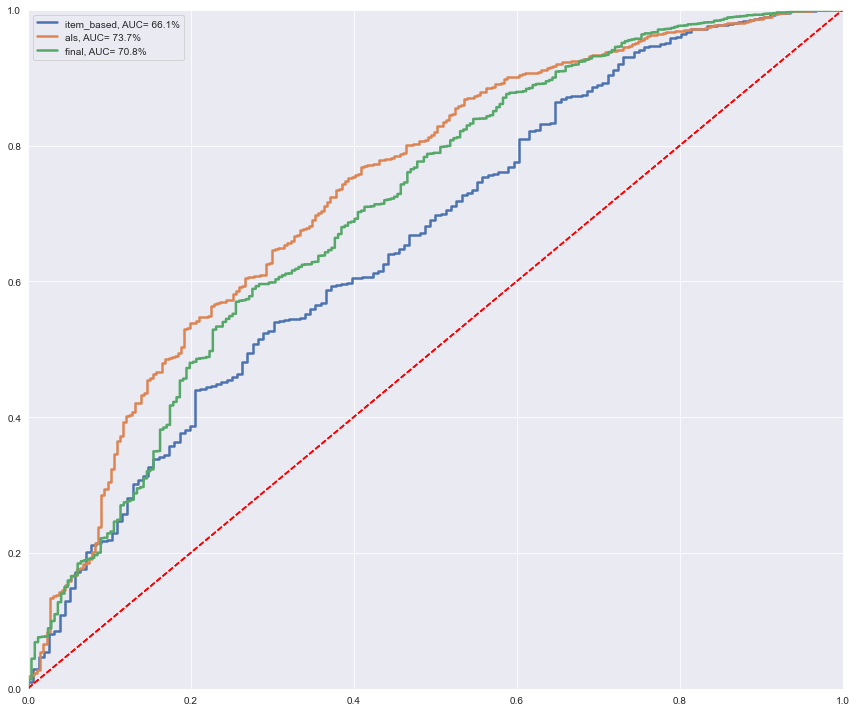

In [65]:
true_binary_item = test_known_pred_item.rating >= 3
true_binary_als = test_known_pred_als.rating >= 3
true_binary_final = test_known_pred_final.rating >= 3
_plot_ROC({"item_based": ROC(test_known_pred_item.prediction, true_binary_item)})
_plot_ROC({"als": ROC(test_known_pred_als.prediction, true_binary_als)})
_plot_ROC({"final": ROC(test_known_pred_final.prediction, true_binary_final)})
plt.show()

**Coverage for each recommendation**

100%|██████████| 393/393 [00:04<00:00, 92.12it/s] 


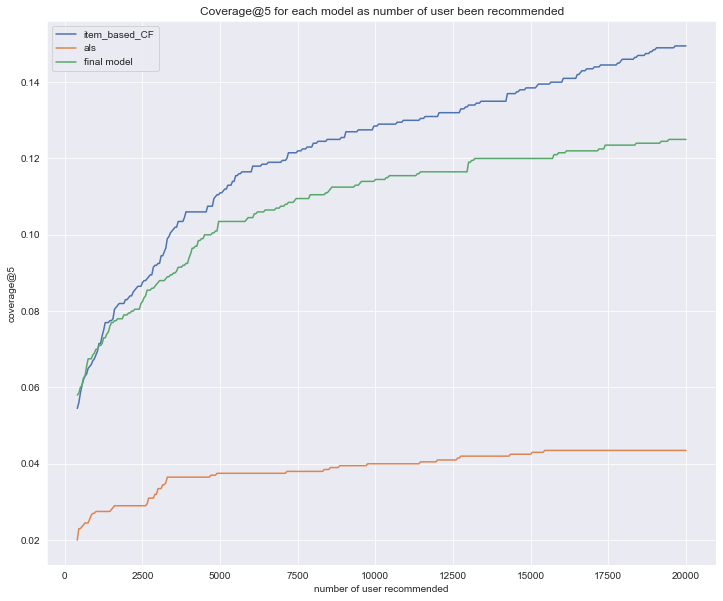

In [40]:
num_users = []
memory_res = []
als_res = []
final_res = []
for i in tqdm(range(400, final_recommend_items.userId.nunique()+1, 50)):
    memory_res.append(memory_based_recommend_items[memory_based_recommend_items.userId.isin(memory_based_recommend_items.userId.unique()[:i])].movieId.nunique()/2000)
    als_res.append(als_recommend_items[als_recommend_items.userId.isin(als_recommend_items.userId.unique()[:i])].movieId.nunique()/2000)
    final_res.append(final_recommend_items[final_recommend_items.userId.isin(final_recommend_items.userId.unique()[:i])].movieId.nunique()/2000)
    num_users.append(i)
pd.DataFrame({'num_users': num_users, 
              'item_based_CF': memory_res,
              'als': als_res,
              'final model': final_res}).set_index('num_users').plot()
plt.xlabel('number of user recommended')
plt.ylabel('coverage@5')
plt.title('Coverage@5 for each model as number of user been recommended')
plt.show()

### Genre related

how many genre covered for each user

In [41]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [42]:
memory_based_recommend_items_genre = memory_based_recommend_items.merge(movies_df)[["userId", "movieId", "prediction", "genres"]]
als_recommend_items_genre = als_recommend_items.merge(movies_df)[["userId", "movieId", "prediction", "genres"]]
final_recommend_items_genre = final_recommend_items.merge(movies_df)[["userId", "movieId", "prediction", "genres"]]
memory_based_recommend_items_genre.genres = memory_based_recommend_items_genre.genres.str.split("|")
als_recommend_items_genre.genres = als_recommend_items_genre.genres.str.split("|")
final_recommend_items_genre.genres = final_recommend_items_genre.genres.str.split("|")
memory_based_genre_counts = memory_based_recommend_items_genre.groupby("userId").genres.apply(lambda x: len(np.unique(np.array(x).flatten()[0])))
als_genre_counts = als_recommend_items_genre.groupby("userId").genres.apply(lambda x: len(np.unique(np.array(x).flatten()[0])))
final_genre_counts = final_recommend_items_genre.groupby("userId").genres.apply(lambda x: len(np.unique(np.array(x).flatten()[0])))
sample_df_genres = sample_df.copy()
sample_df_genres.genres = sample_df_genres.genres.str.split("|")
all_user_genre_counts = sample_df_genres.groupby("userId").genres.apply(lambda x: len(np.unique(np.array(x).flatten()[0])))
genre_recom = pd.Series({"item_based": (memory_based_genre_counts/all_user_genre_counts).mean(),
 "als (base model)": (als_genre_counts/all_user_genre_counts).mean(),
 "final (hybrid model)": (final_genre_counts/all_user_genre_counts).mean()})
display(genre_recom)

item_based              0.586878
als (base model)        0.535450
final (hybrid model)    0.613992
dtype: float64

### Observation

**base recommender vs. final recommender**

what has been improved?


waht 

**Frequent Users vs. Non-Frequent Users**

Text(0.5, 1.0, '# of ratings for users')

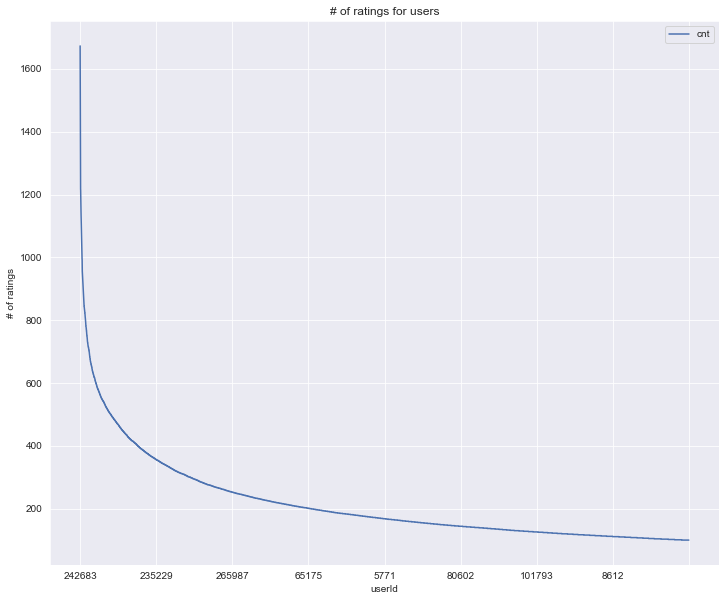

In [43]:
user_rating_cnt = sample_df.userId.value_counts().to_frame("cnt")
user_rating_cnt['userId'] = user_rating_cnt.index.astype(str)
user_rating_cnt.plot(x="userId",y="cnt")
plt.ylabel("# of ratings")
plt.title("# of ratings for users")

From the above graph we could see our whole dataset(sampled from movielens) contains a few power users and most of the users have rated about 400 or less. We will set number of ratings greater than 400 as power users and less than 400 ratings as non frequent users. We will compare how the system performs on two groups.

In [44]:
def frequent_user(sample_df):
    """
    return list of userId that has rated more than 400 movies
    """
    user_rating_cnt = sample_df.userId.value_counts().to_frame("cnt")
    return list(user_rating_cnt[user_rating_cnt.cnt > 400].index)

def non_frequent_user(sample_df):
    """
    return list of userId that has rated less or equal to 400 movies
    """
    user_rating_cnt = sample_df.userId.value_counts().to_frame("cnt")
    return list(user_rating_cnt[user_rating_cnt.cnt <= 400].index)

In [45]:
freq_userId = frequent_user(sample_df)
non_freq_userId = non_frequent_user(sample_df)

In [46]:
test_freq = test_known_pred_final[test_known_pred_final.userId.isin(freq_userId)]
test_non_freq = test_known_pred_final[test_known_pred_final.userId.isin(non_freq_userId)]

Text(0.5, 1.0, 'RMSE between frequent users and non frequent users')

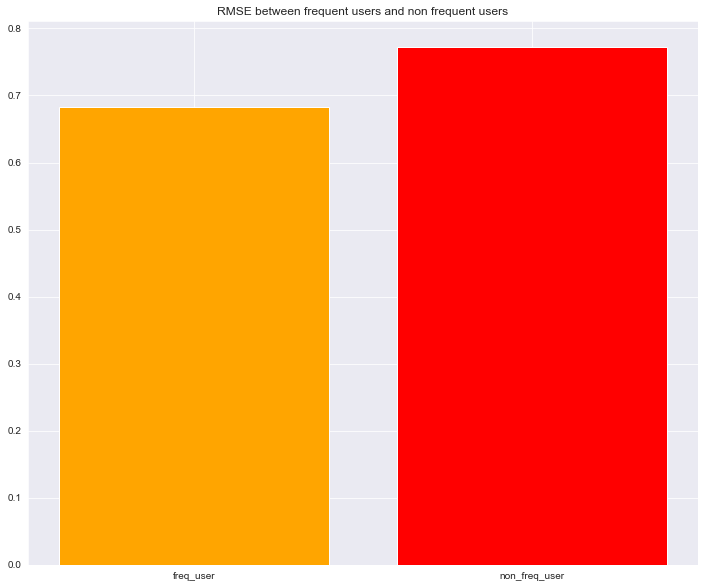

In [47]:
freq_rmse = rmse_numpy(test_freq.rating,test_freq.prediction)
non_freq_rmse = rmse_numpy(test_non_freq.rating,test_non_freq.prediction)
plt.bar(x=['freq_user','non_freq_user'],height=[freq_rmse,non_freq_rmse],color=['orange','red'])
plt.title("RMSE between frequent users and non frequent users")

For frequent user, the RMSE is smaller than non frequent user. That indicates the system could give better recommendations to users who often visit our website and give inputs. The system might need to improve on those users who give less about their feedback but the gap between the two groups is minor (about 0.1 unit of rating). 

**Popular Movies vs. Niche Movies**

Text(0.5, 1.0, '# of ratings received by movie')

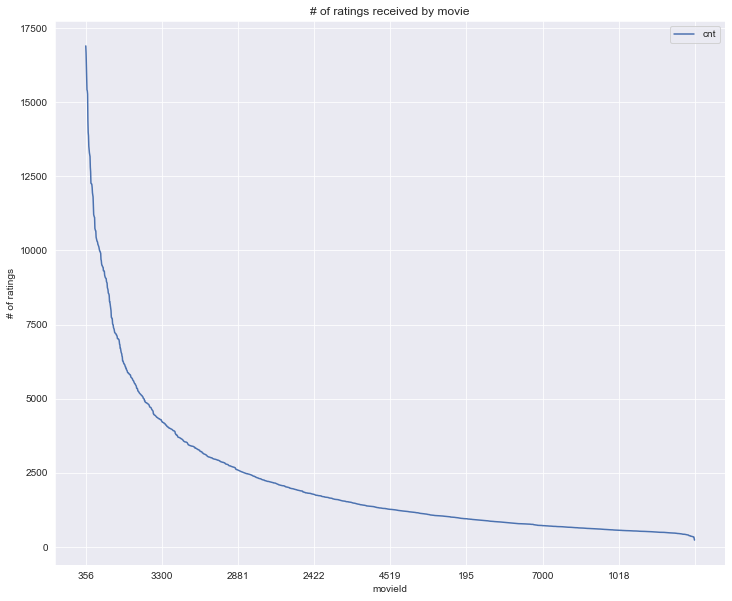

In [48]:
movie_rating_cnt = sample_df.movieId.value_counts().to_frame("cnt")
movie_rating_cnt['movieId'] = movie_rating_cnt.index.astype(str)
movie_rating_cnt.plot(x="movieId",y="cnt")
plt.ylabel("# of ratings")
plt.title("# of ratings received by movie")

We then investigate from movie's perspective. From above graph, we could see that we could set the cutoff between popular movies and niche movies at about 5000 ratings.

In [49]:
def popular_movie(sample_df):
    """
    return list of movieId that has been rated more than 5000 times
    """
    movie_rating_cnt = sample_df.movieId.value_counts().to_frame("cnt")
    return list(movie_rating_cnt[movie_rating_cnt.cnt > 5000].index)

def niche_movie(sample_df):
    """
    return list of movieId that has been rated less or equal to 5000 times
    """
    movie_rating_cnt = sample_df.movieId.value_counts().to_frame("cnt")
    return list(movie_rating_cnt[movie_rating_cnt.cnt <= 5000].index)

In [50]:
pop_movieId = popular_movie(sample_df)
niche_movieId = niche_movie(sample_df)

In [51]:
test_pop = test_known_pred_final[test_known_pred_final.movieId.isin(pop_movieId)]
test_niche = test_known_pred_final[test_known_pred_final.movieId.isin(niche_movieId)]

Text(0.5, 1.0, '# of niche movies recommeded compare to popular movies')

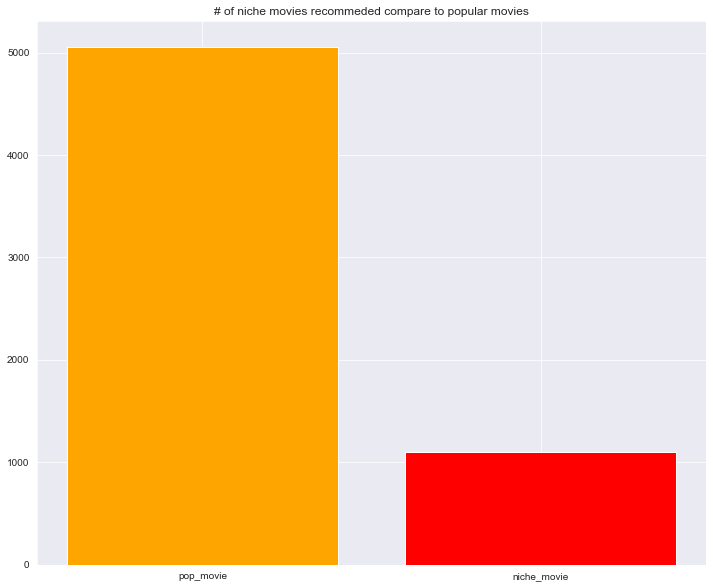

In [52]:
plt.bar(x=['pop_movie','niche_movie'],height=[len(test_pop),len(test_niche)],color=['orange','red'])
plt.title("# of niche movies recommeded compare to popular movies")

Among the existed movies in our test set, we see lots of the movies are considered "popular" movies. That might make sense, because, as mentioned in the lecture, popularity based models are somehow robust. Conformity might exist among people and that might cause these movies becoming popular. Later on, we should find strategies to better the exploration experience on niche movies so that this popular to niche ratio could be shrinked. This improvement would further serve our business goal which is to provide movies that fit for people regardless of the popularity.

# Conclusion

Overall this project has produced a sequential model of recommendation algorithms that could serve users with personalized movies. The system first goes through a simple but fast algorithm to select a collection of movies. Then these movies would be feeded alongside with the user identity into our wide and deep model to produce a well treated list of k(right now 5) movies that best fit the user's taste. Through the experiment process, we find out different models (baselines or our full pipeline model) have their own advantage on different metrics. We finally choose our full pipeline model because although the metrics are not the best but the ability to generalize cannot be replaced by baseline models which only perform memorization of the data. The ability to generalize aligns with our business rule and make users explore new topics (genres in this case) better. 